# Анализ фондового рынка. 

<b>Описание проекта</b><br>
Из импортированных файлов  с информацией о динамике цен акций на фондовом рынке необходимо собрать датафрейм, осуществить предобработку, добавить метрики и провести исследовательский анализ цены за последние 3 года. В исследовании использовать скользящие средние, экспотенциальные скользящие средние и RSI индикатор.


**Данные**: 

Экспорт котировок Газпром АО, рынок Мосбиржа

https://www.finam.ru/quote/moex/gazp/export/ 

**Ход работы**
1. Загрузили информацию об акциях с сайте finam.ru с интервалом 3 года, периодичностью 1 день.
2. Собрали информацию из файлов в единый датафрейм.
3. Осуществили предобработку дат и заголовков.
4. Построили линейные графики динамики цены для каждой акции.
5. Для каждой акции нашли дни максимального изменения цены (взлета и падения).
6. Нашли скользящие средние (периоды 10, 50, 100) для каждой акции. 
7. Построили в цикле графики объема для каждого тикера.
8. Реализовали в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализовали с помощью функции. 
9. Добавили экспоненциальные скользящие средние для каждого тикера с периодом 50.
10. Осуществили расчет индикатора RSI.
11.  Создали функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора. <br>

In [ ]:
import pandas as pd
import glob
import warnings

In [2]:
# Избавимся от надоедливых предупреждений
warnings.filterwarnings("ignore")

**1. Загрузили информацию об акциях с сайте finam.ru с интервалом 3 года, периодичностью 1 день.**

In [3]:
files = glob.glob('*.csv')

**2. Собрали информацию из файлов в единый датафрейм.**

In [4]:
# Пустой список для хранения датафреймов
n = []

for file in files:

    data = pd.read_csv(file, sep=';')
    n.append(data)

df = pd.concat(n, ignore_index=True)

In [5]:
df

,<TICKER>,<PER>,<DATE>,<TIME>,<OPEN>,<HIGH>,<LOW>,<CLOSE>,<VOL>
0,GAZP,D,201215,0,199.01,202.29,197.05,201.00,65473740
1,GAZP,D,201216,0,201.01,206.20,199.54,206.20,75214780
2,GAZP,D,201217,0,206.70,215.38,206.51,214.52,159538150
3,GAZP,D,201218,0,214.00,214.50,207.22,212.69,133717910
4,GAZP,D,201221,0,209.91,209.99,200.80,203.46,123517830
...,...,...,...,...,...,...,...,...,...
3737,YNDX,D,231211,0,2339.00,2343.80,2191.40,2207.60,2085576
3738,YNDX,D,231212,0,2219.80,2284.40,2201.00,2257.00,1883367
3739,YNDX,D,231213,0,2243.00,2288.00,2230.20,2266.80,1087960
3740,YNDX,D,231214,0,2271.00,2275.60,2140.00,2157.60,1559511


**3. Осуществили предобработку дат и заголовков.**

In [6]:
df.columns = ['ticker', 'per', 'date', 'time', 'open', 'high', 'low', 'close', 'vol']
df['date'] = pd.to_datetime(df['date'], format='%y%m%d')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3742 entries, 0 to 3741
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ticker  3742 non-null   object        
 1   per     3742 non-null   object        
 2   date    3742 non-null   datetime64[ns]
 3   time    3742 non-null   int64         
 4   open    3742 non-null   float64       
 5   high    3742 non-null   float64       
 6   low     3742 non-null   float64       
 7   close   3742 non-null   float64       
 8   vol     3742 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(2), object(2)
memory usage: 263.2+ KB


**4. Построили линейные графики динамики цены для каждой акции.**

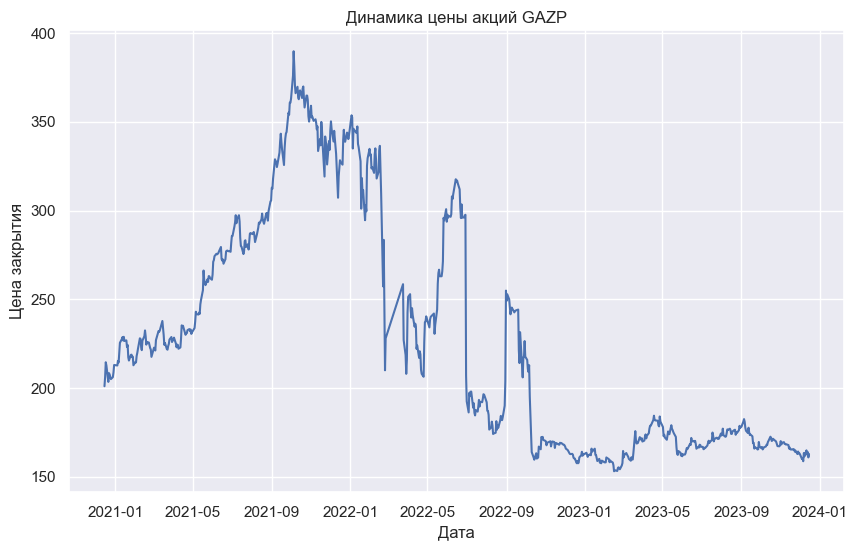

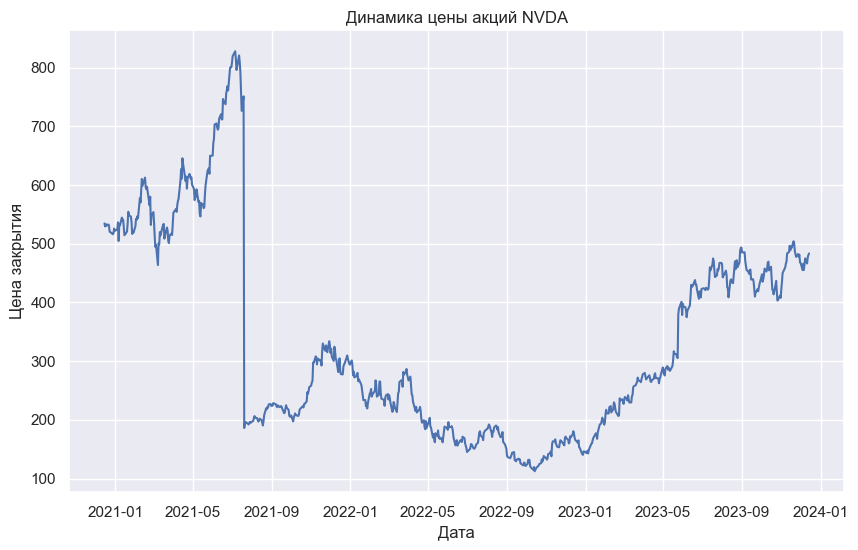

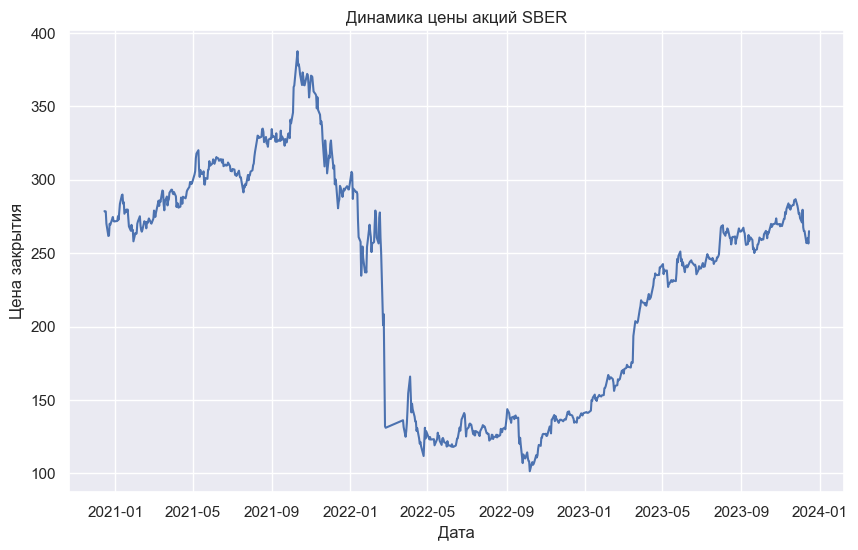

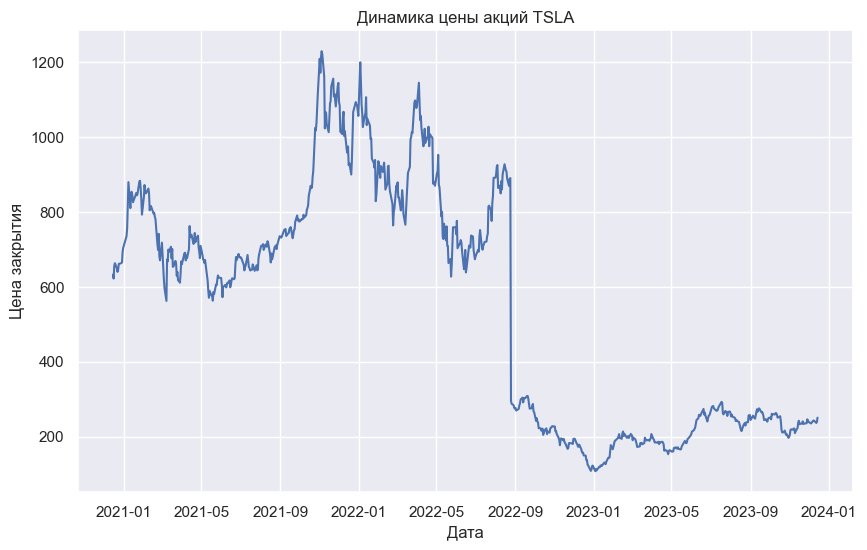

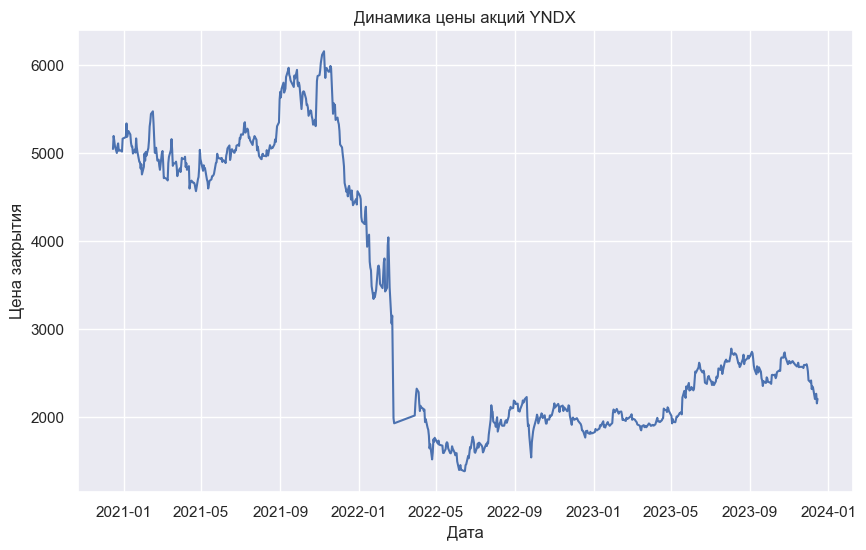

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="darkgrid")

tickers = df['ticker'].unique()

for ticker in tickers:
    
    df_ticker = df[df['ticker'] == ticker]

    plt.figure(figsize=(10, 6))
    plt.plot(df_ticker['date'], df_ticker['close'], label=f'Цена закрытия {ticker}')
    plt.title(f'Динамика цены акций {ticker}')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.show()

**5. Для каждой акции нашли дни максимального изменения цены (взлета и падения).**

В данном случае можно использовать 2 подхода к изучению максимального изменения цены: разница между high и low или разница между close и open. Особенности каждого из подходов заключаются в следующем:

**Использование high - low:**
- Этот метод измеряет максимальный диапазон колебаний цены акции в течение одного торгового дня.
- Он показывает волатильность акции за день, но не указывает, закрылась ли акция выше или ниже цены открытия.
- Это полезно для оценки общей волатильности и потенциальных рисков торговли этой акцией.

**Использование close - open:**
- Этот метод показывает чистое изменение цены акции за день, т.е. разницу между ценой закрытия и ценой открытия.
- Он дает представление о том, двигалась ли акция в целом вверх или вниз в течение дня.
- Это полезно для понимания общего направления движения цен и настроений на рынке.

Составим отчеты, использовав оба способа

In [9]:
# Расчет абсолютных изменений цен по двум методам
df['change_hl'] = abs(df['high'] - df['low'])
df['change_co'] = abs(df['close'] - df['open'])

# Нахождение максимального абсолютного изменения по методу high-low
max_change_hl = df.groupby('ticker')['change_hl'].idxmax()
report_hl = df.loc[max_change_hl, ['ticker', 'date', 'change_hl']].reset_index(drop=True)

# Нахождение максимального абсолютного изменения по методу close-open
max_change_co = df.groupby('ticker')['change_co'].idxmax()
report_co = df.loc[max_change_co, ['ticker', 'date', 'change_co']].reset_index(drop=True)

In [10]:
report_hl

,ticker,date,change_hl
0,GAZP,2022-02-24,128.49
1,NVDA,2021-04-12,48.29
2,SBER,2022-02-24,97.95
3,TSLA,2021-11-09,161.89
4,YNDX,2022-02-24,1254.00


In [11]:
report_co

,ticker,date,change_co
0,GAZP,2022-06-30,92.60
1,NVDA,2021-04-12,36.55
2,SBER,2022-02-24,54.40
3,TSLA,2021-11-09,150.08
4,YNDX,2022-02-24,964.00


Может показаться, что результаты неверны, т.к., например, у тикера TSLA максимальное изменение, равное 150.08 или 161.89, не соответствует действительности, потому что из графиков видно что примерно в конце лета 2022 года (а точнее, в период между 24.08.2022 и 25.08.2022) наблюдается существенное падение.

In [12]:
df[(df['ticker'] == 'TSLA') & (df['date'].isin(['2022-08-24', '2022-08-25']))]

,ticker,per,date,time,open,high,low,close,vol,change_hl,change_co
2670,TSLA,D,2022-08-24,0,892.51,910.47,889.88,890.91,333021,20.59,1.60
2671,TSLA,D,2022-08-25,0,302.27,302.94,291.64,296.13,1352251,11.30,6.14


Но это объясняется разницой в цене между закрытием одного торгового дня и открытием следующего. Эти разрывы в цене между обычно связаны с тем, что фондовая биржа не работает круглосуточно, а имеет определенные часы торговли. После закрытия основной торговой сессии на бирже акции могут продолжать торговаться на внебиржевых платформах. Цены, установленные в результате этих сделок, могут сильно отличаться от цен закрытия основной сессии, особенно если после закрытия биржи появляются значимые новости или финансовые отчеты.

Поэтому, если мы хотим проанализировать максимальное изменение цены за сутки, то стоит изучить разницу между ценами закрытия одного и следущего дней

In [13]:
df_sorted = df.sort_values(by=['ticker', 'date'])
df_sorted['next_close'] = df_sorted.groupby('ticker')['close'].shift(-1)
df_sorted['daily_change'] = df_sorted['next_close'] - df_sorted['close']

# Нахождение дней с максимальными увеличениями и уменьшениями цен
max_increase_day = df_sorted.groupby('ticker')['daily_change'].idxmax()
max_decrease_day = df_sorted.groupby('ticker')['daily_change'].idxmin()

report_increase = df_sorted.loc[max_increase_day, ['ticker', 'date', 'daily_change']].reset_index(drop=True)
report_decrease = df_sorted.loc[max_decrease_day, ['ticker', 'date', 'daily_change']].reset_index(drop=True)

report = pd.DataFrame(columns=['ticker', 'date_max_increase', 'max_increase', 'date_max_decrease', 'max_decrease'])

for ticker in df['ticker'].unique():
    max_inc_idx = max_increase_day[ticker]
    max_dec_idx = max_decrease_day[ticker]
    report = report.append({
        'ticker': ticker,
        'date_max_increase': df_sorted.loc[max_inc_idx, 'date'],
        'max_increase': df_sorted.loc[max_inc_idx, 'daily_change'],
        'date_max_decrease': df_sorted.loc[max_dec_idx, 'date'],
        'max_decrease': df_sorted.loc[max_dec_idx, 'daily_change']
    }, ignore_index=True)

report

,ticker,date_max_increase,max_increase,date_max_decrease,max_decrease
0,GAZP,2022-08-30,50.90,2022-06-29,-90.65
1,NVDA,2023-05-24,74.57,2021-07-19,-565.09
2,SBER,2023-07-28,18.15,2022-02-22,-76.35
3,TSLA,2021-12-31,143.12,2022-08-24,-594.78
4,YNDX,2022-02-14,481.80,2022-02-22,-1164.80


**6. Нашли скользящие средние (периоды 10, 50, 100) для каждой акции.**

In [14]:
periods = [10, 50, 100]

for period in periods:
    df[f'SMA_{period}'] = df.groupby('ticker')['close'].transform(lambda x: x.rolling(window=period).mean())

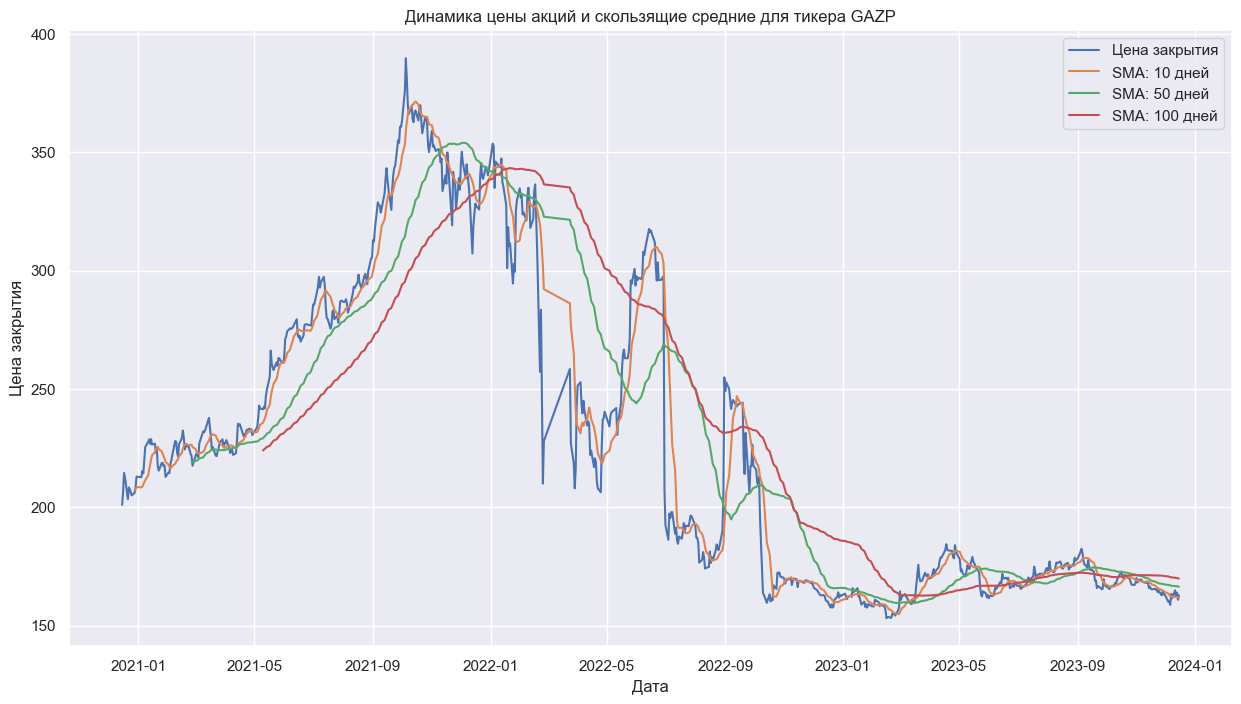

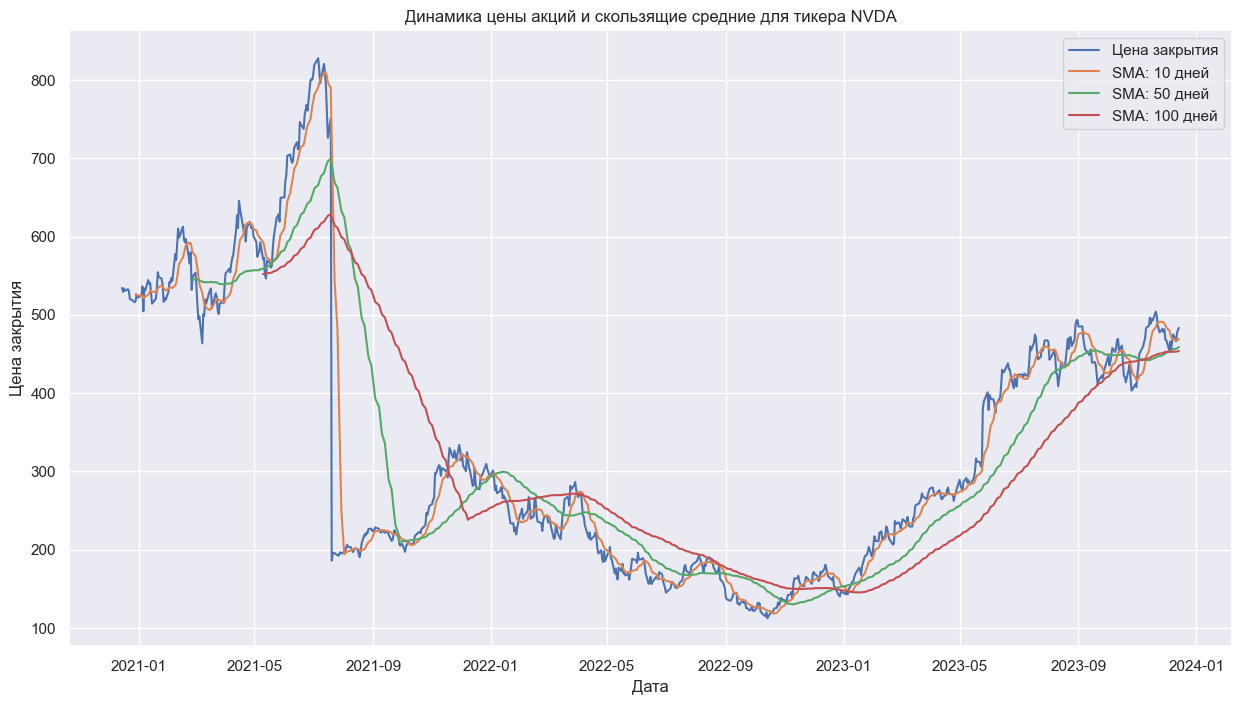

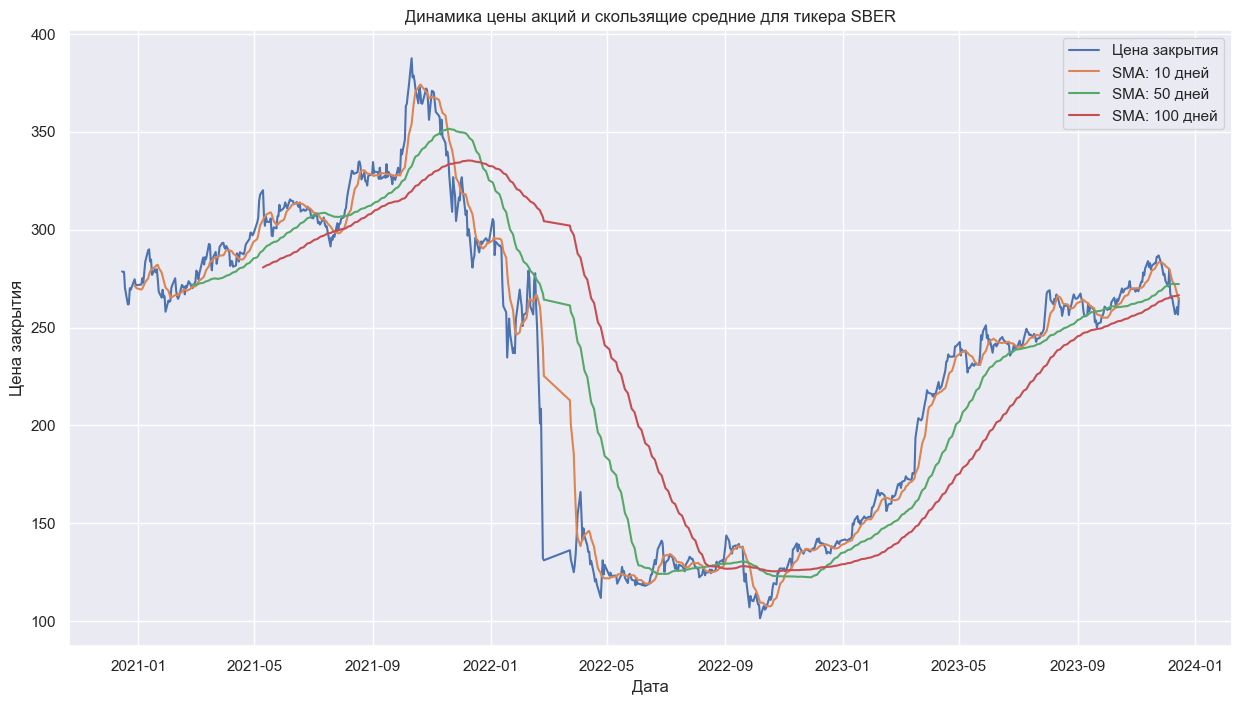

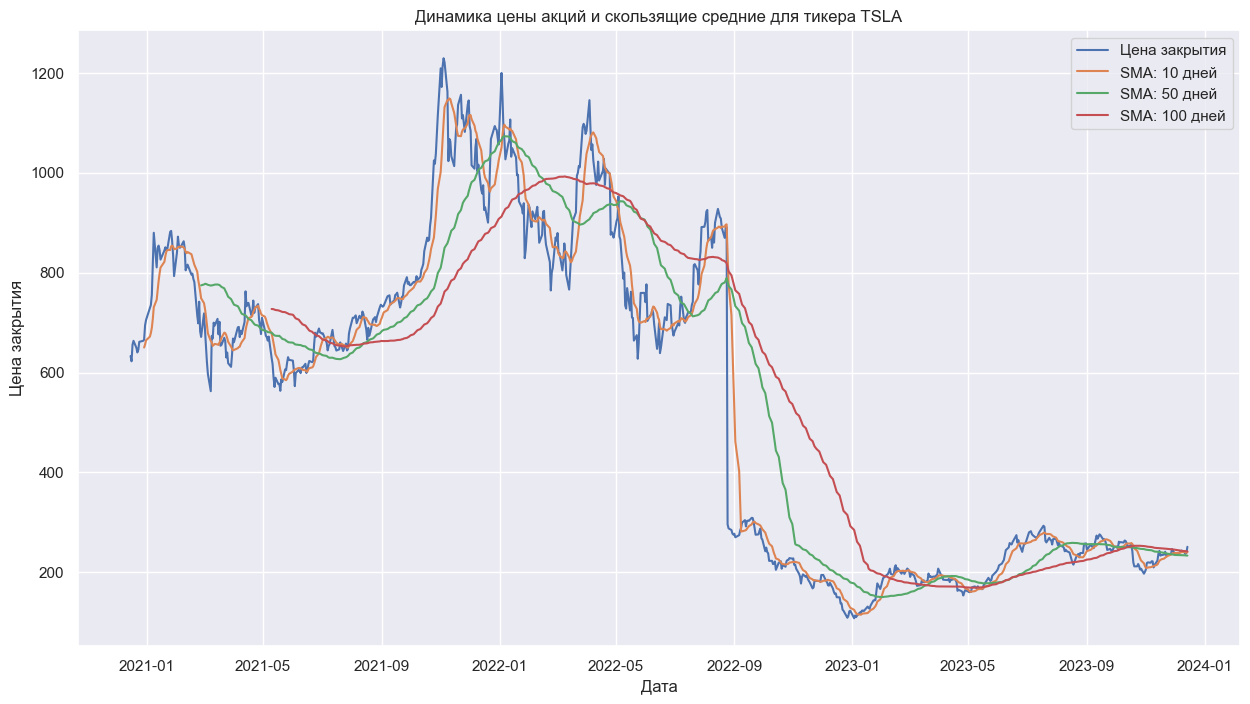

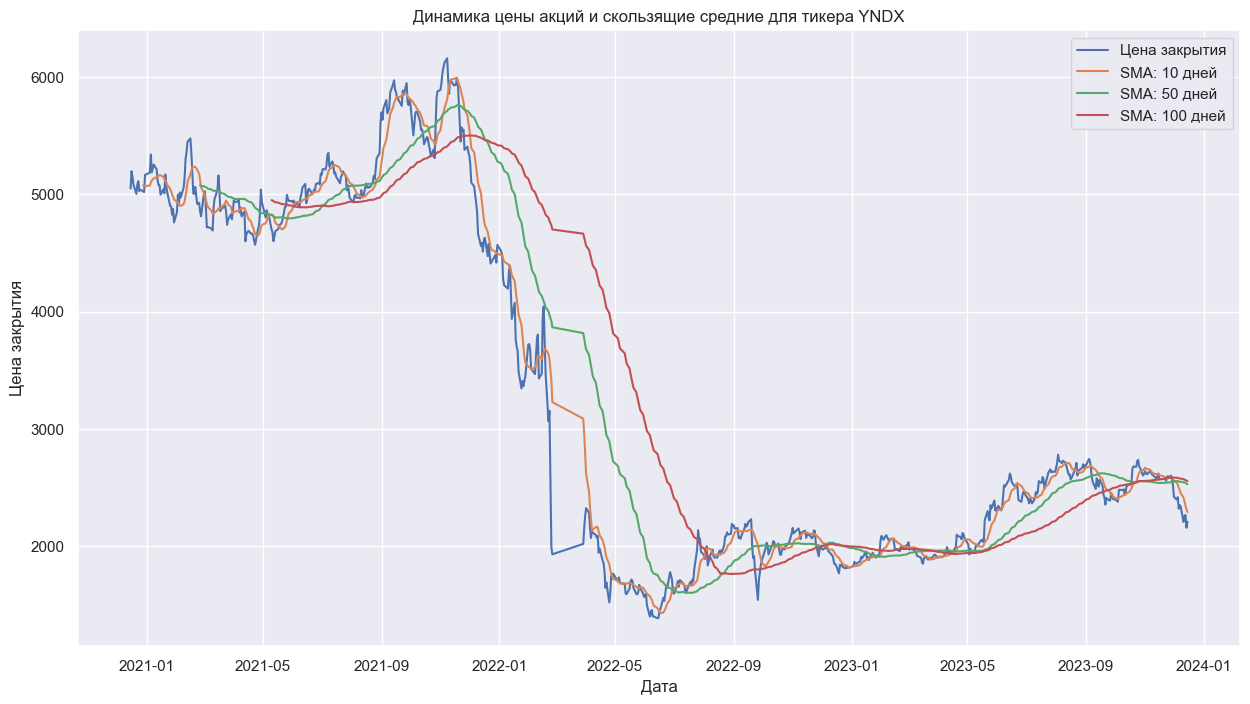

In [15]:
for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker]

    plt.figure(figsize=(15, 8))
    plt.plot(df_ticker['date'], df_ticker['close'], label=f'Цена закрытия')
    
    for period in periods:
        plt.plot(df_ticker['date'], df_ticker[f'SMA_{period}'], label=f'SMA: {period} дней')

    plt.title(f'Динамика цены акций и скользящие средние для тикера {ticker}')
    plt.xlabel('Дата')
    plt.ylabel('Цена закрытия')
    plt.legend()
    plt.show()

In [16]:
df_ticker[f'SMA_{period}']

3000         NaN
3001         NaN
3002         NaN
3003         NaN
3004         NaN
          ...   
3737    2571.972
3738    2568.116
3739    2564.232
3740    2559.508
3741    2555.232
Name: SMA_100, Length: 742, dtype: float64

Простая скользящая средняя (SMA) помогает сгладить ценовые данные для выявления тенденций и закономерностей.

Преимущества SMA:
- SMA помогает сгладить случайные колебания цен и выявить долгосрочные тенденции, делая данные более читаемыми.
- SMA является одним из самых простых индикаторов для понимания и применения.

Недостатки SMA:
- Основной недостаток SMA заключается в её запаздывающем характере. Поскольку SMA основана на прошлых данных, она может опаздывать с реакцией на текущие изменения рынка.
- Резкие изменения цен могут существенно искажать SMA, особенно на малых временных промежутках.

Что же касается зависимости SMA от количества периодов, то SMA с меньшим количеством периодов (например, 10), как было уже сказано, более чувствительна к недавним изменениям цен, что может привести к более резким и частым сигналам. SMA с большим количеством периодов (например, 50 или 100) сглаживает данные на более длительном временном промежутке, что делает её более устойчивой к краткосрочным колебаниям, что подходит для выявления долгосрочных тенденций.

**7. Построили в цикле графики объема для каждого тикера.**

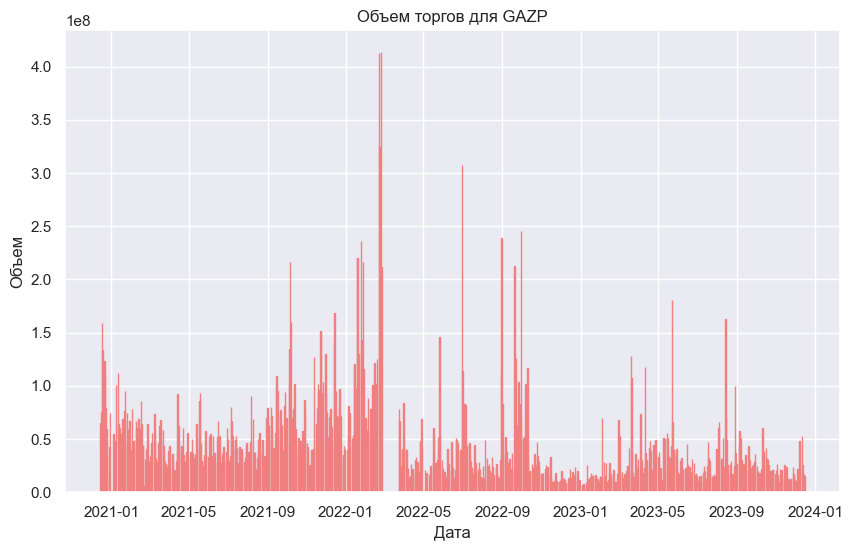

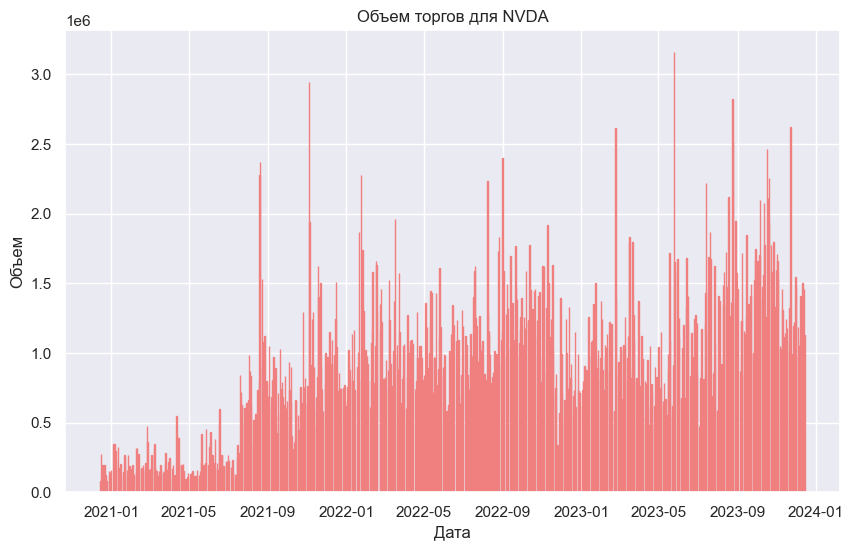

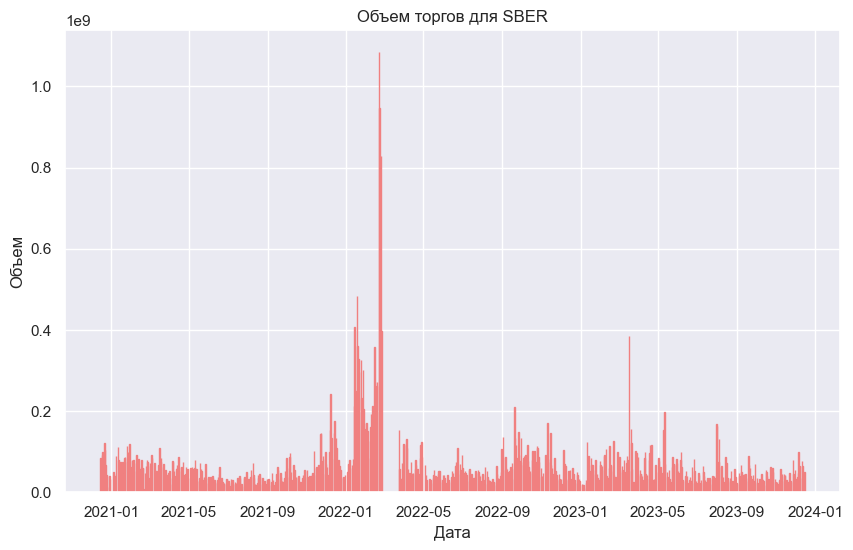

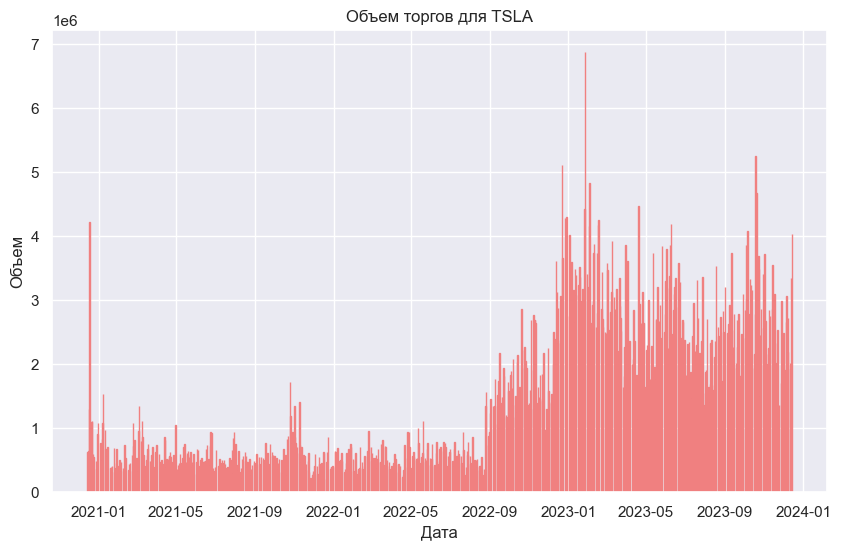

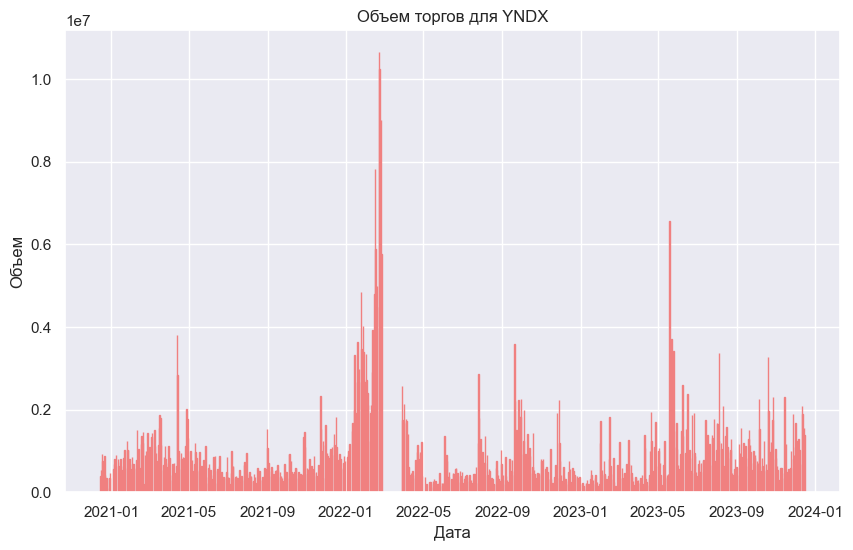

In [17]:
for ticker in tickers:

    df_ticker = df[df['ticker'] == ticker]

    plt.figure(figsize=(10, 6))
    plt.bar(df_ticker['date'], df_ticker['vol'], label=f'Объем торгов {ticker}', edgecolor='lightcoral')
    plt.title(f'Объем торгов для {ticker}')
    plt.xlabel('Дата')
    plt.ylabel('Объем')
    plt.show()

**8. Реализовали в цикле для каждого тикера последовательно: график цены вместе с скользящими средними с периодом 50, 100 и график объема, реализовали с помощью функции.**


In [18]:
def ticker_plot(ticker, year):

    df_filtered = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)]

    df_filtered['SMA_50'] = df_filtered['close'].rolling(window=50).mean()
    df_filtered['SMA_100'] = df_filtered['close'].rolling(window=100).mean()
    
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Ось Y для цены закрытия и скользящих средних
    ax1.plot(df_filtered['date'], df_filtered['close'], label='Цена закрытия', color='blue')
    ax1.plot(df_filtered['date'], df_filtered['SMA_50'], label='SMA 50', color='orange')
    ax1.plot(df_filtered['date'], df_filtered['SMA_100'], label='SMA 100', color='green')
    ax1.set_xlabel('Дата')
    ax1.set_ylabel('Цена закрытия', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    # Ось Y для объема торгов
    ax2 = ax1.twinx()
    ax2.bar(df_filtered['date'], df_filtered['vol'], alpha=0.3, color='firebrick')
    ax2.set_ylabel('Объем', color='firebrick')
    ax2.tick_params(axis='y', labelcolor='firebrick')

    ax1.legend(loc='upper right')    

    plt.title(f'Цена закрытия, скользящие средние и объем торгов для {ticker} в {year} году')
    fig.tight_layout()
    plt.show()

Рассмотрим реализацию написанной функции, построив графики для тикеров за 2022 год

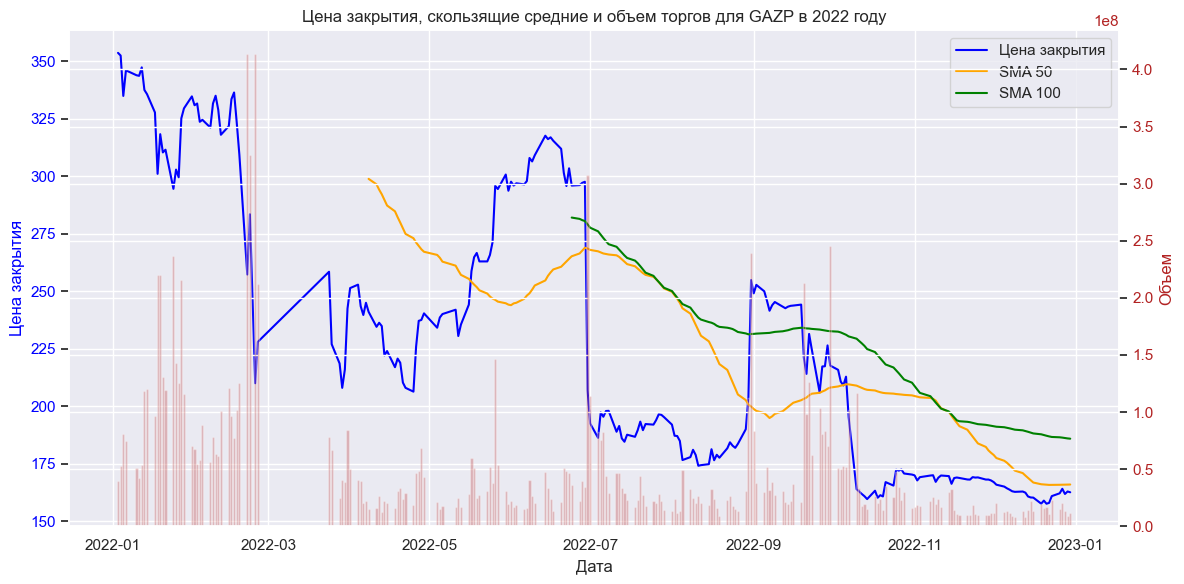

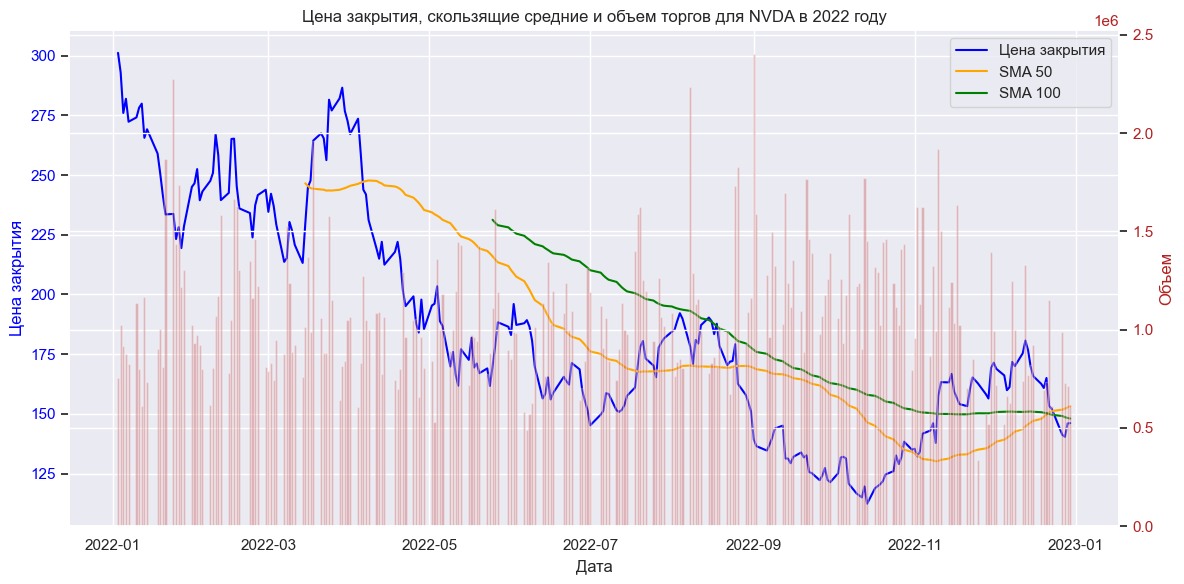

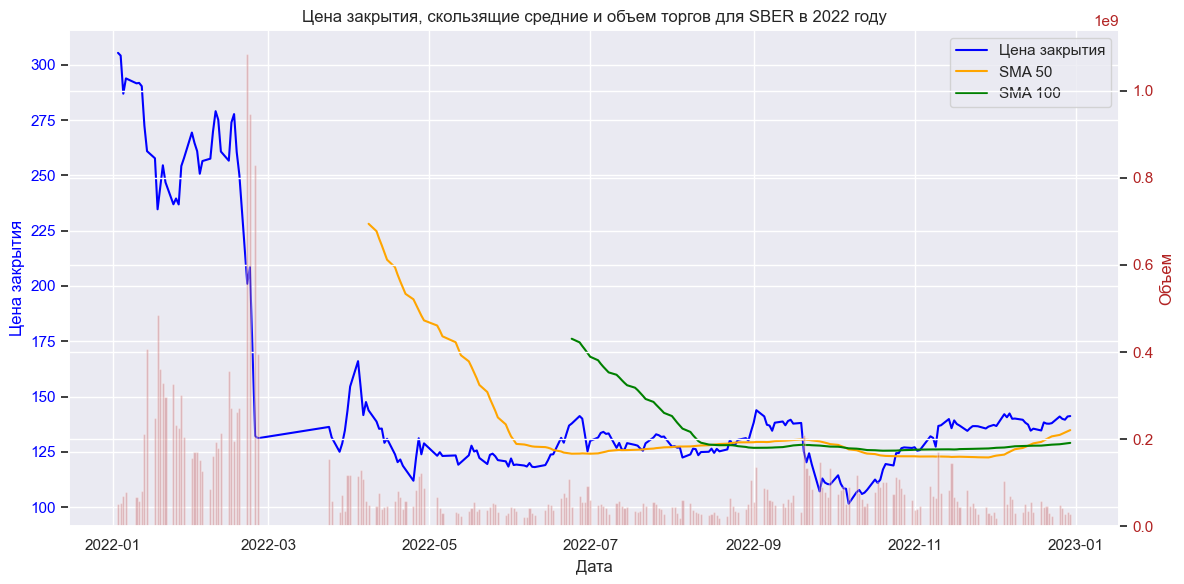

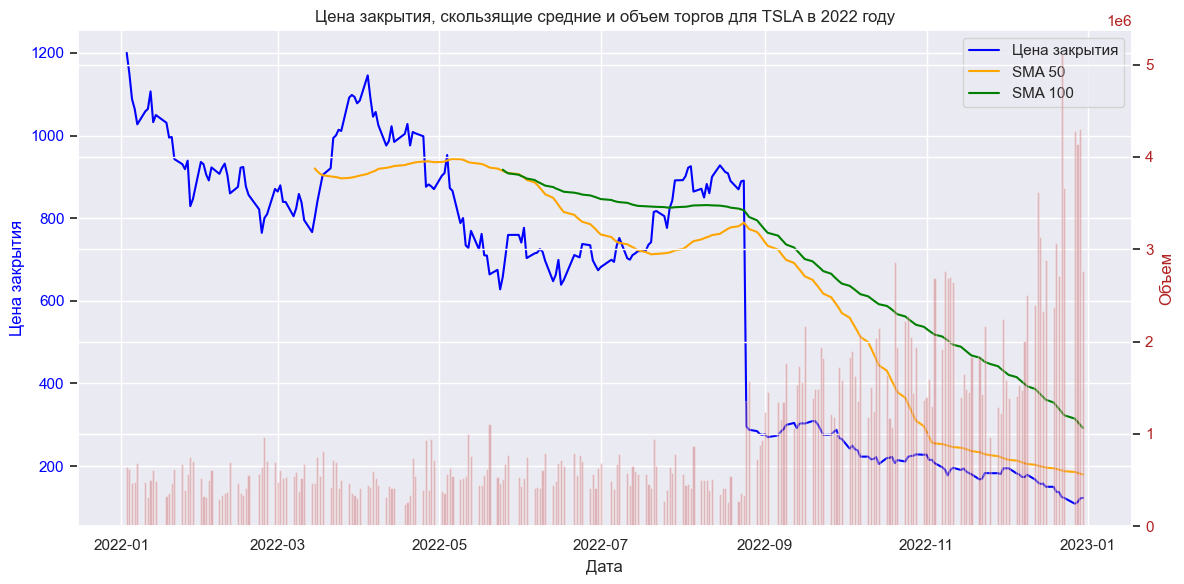

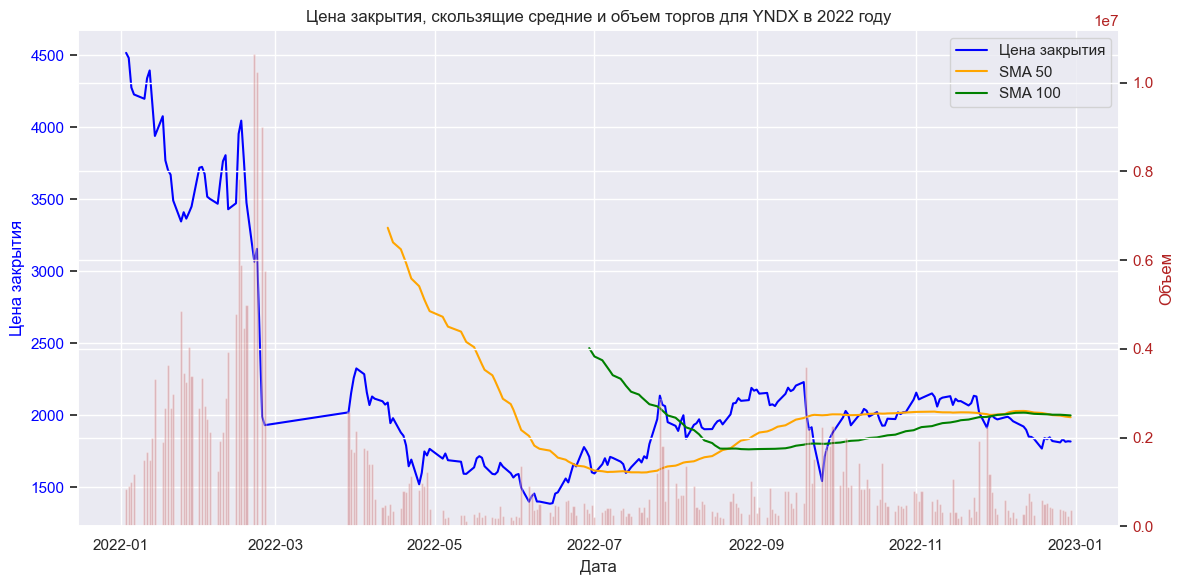

In [19]:
for ticker in tickers:
        ticker_plot(ticker, 2022)

Скользящие средние начинаются не с самого начала графика, т.к. при расчете SMA на графике они начинают отображаться только после того, как накапливается достаточное количество наблюдений для их вычисления.

Примечательно, что резкое падение цены акции сопровождается значительным увеличением объема торгов (это особенно хорошо прослеживается на примерах SBER и YNDX). Этому можно дать несколько объяснений:
- Одной из наиболее распространенных причин такого явления являются панические продажи. Инвесторы, реагируя на негативные новости или неблагоприятные экономические индикаторы, могут массово продавать акции, что приводит к увеличению объема торгов и одновременному снижению цен.

- Многие трейдеры используют стоп-лосс ордера для ограничения своих потерь. Когда цена акции падает до определенного уровня, активируются эти ордера, увеличивая объем продаж и ускоряя падение цены.

**9. Добавили экспоненциальные скользящие средние для каждого тикера с периодом 50.**

In [20]:
df['EMA_50'] = df.groupby('ticker')['close'].transform(lambda x: x.ewm(span=50, adjust=False).mean())

Функция `ewm` была использована без корректировки (`adjust=False`) для того, чтобы EMA был более чувствительным к последним изменениям в данных, что более предпочтительно для анализа финансового рынка

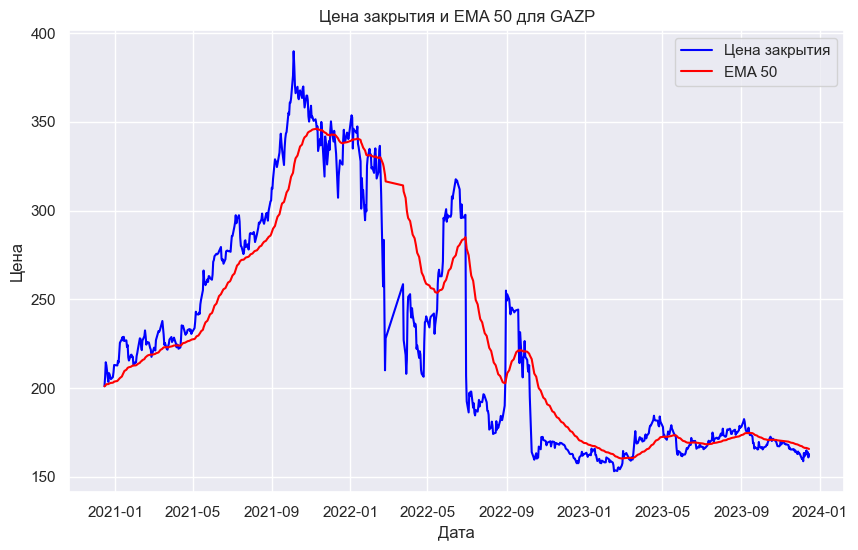

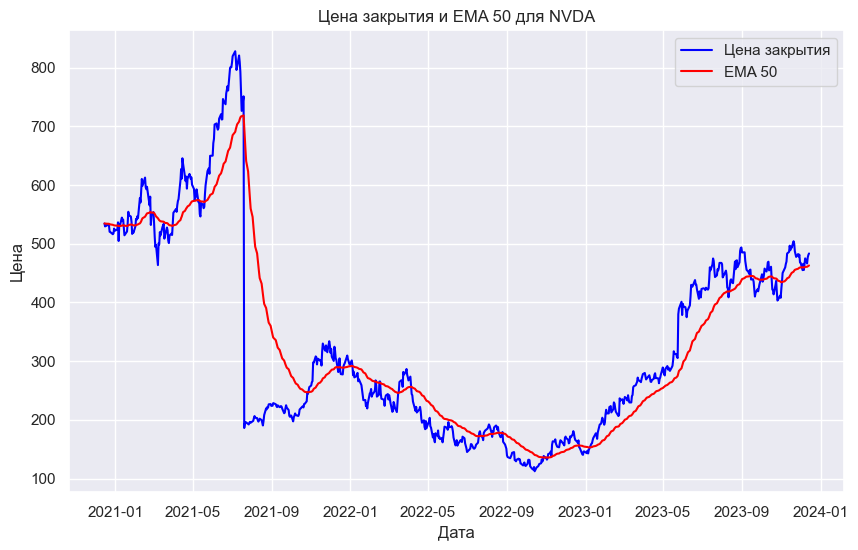

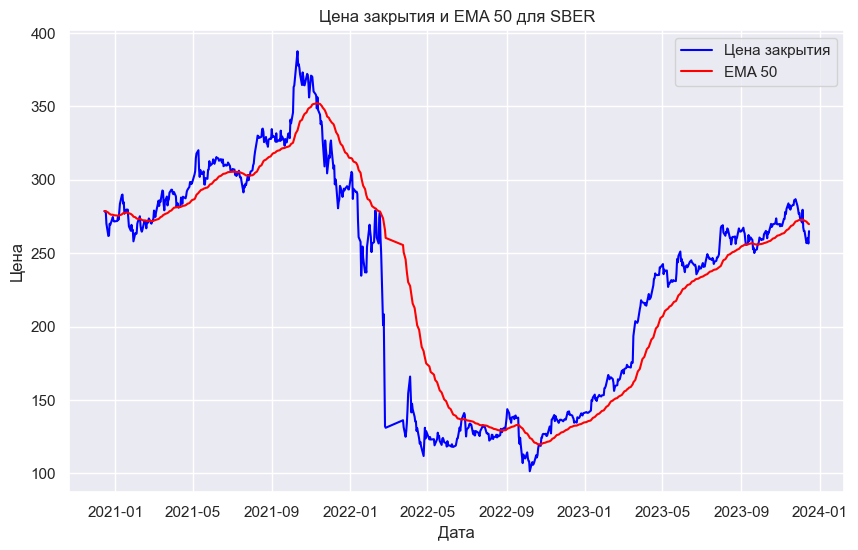

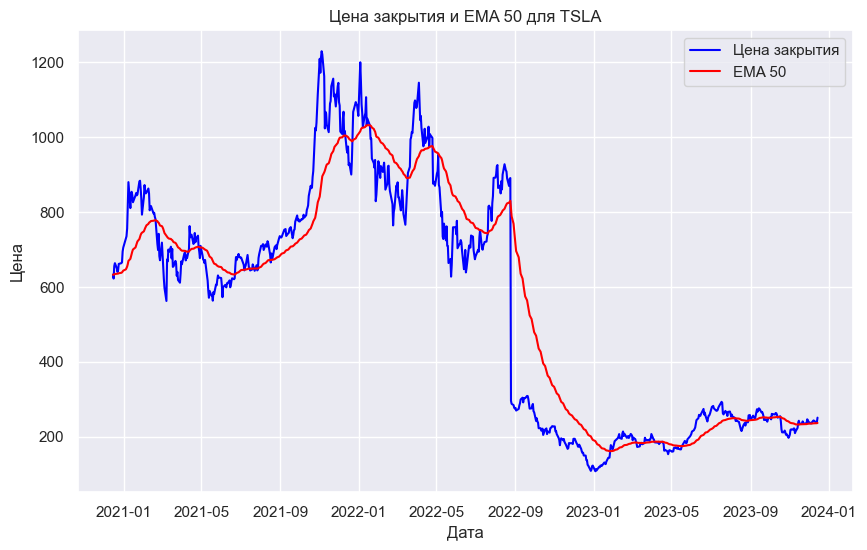

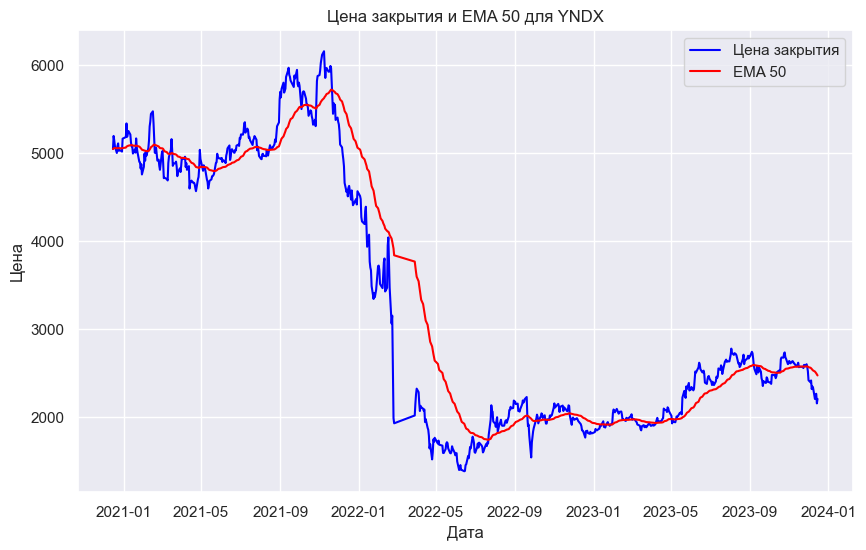

In [21]:
for ticker in tickers:
    df_ticker = df[df['ticker'] == ticker]

    plt.figure(figsize=(10, 6))
    plt.plot(df_ticker['date'], df_ticker['close'], label='Цена закрытия', color='blue')
    plt.plot(df_ticker['date'], df_ticker['EMA_50'], label='EMA 50', color='red')
    plt.title(f'Цена закрытия и EMA 50 для {ticker}')
    plt.xlabel('Дата')
    plt.ylabel('Цена')
    plt.legend()
    plt.show()

Если сравнивать EMA и SMA, то можно выделить следующие особенности:

- EMA более чувствительна к недавним ценовым изменениям, в то время как SMA предоставляет более сглаженный и медленный анализ.
- EMA быстрее реагирует на изменения рынка, что может быть как преимуществом, так и недостатком – она может дать больше ложных сигналов в периоды высокой волатильности.
- Выбор между EMA и SMA зависит от стиля торговли и целей анализа. EMA предпочтительнее для краткосрочных стратегий и волатильных рынков, в то время как SMA лучше подходит для определения долгосрочных тенденций.

**10. Осуществили расчет индикатора RSI.**

In [22]:
def rsi(data, window_length=14):

    delta = data['close'].diff()

    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)

    avg_gain = gain.rolling(window=window_length, min_periods=window_length).mean()
    avg_loss = loss.rolling(window=window_length, min_periods=window_length).mean()

    rs = avg_gain / avg_loss

    rsi = 100 - (100 / (1 + rs))

    return rsi

In [23]:
for ticker in tickers:
    df.loc[df['ticker'] == ticker, 'RSI'] = rsi(df[df['ticker'] == ticker])

**11.  Создали функцию для вывода графиков: цены, скользящей средней (тип и период определите самостоятельно) и отдельный график для RSI индикатора.**

In [24]:
def plot_price_ema_rsi(ticker, year):

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    df_filtered = df[(df['ticker'] == ticker) & (df['date'].dt.year == year)]

    # График цены закрытия и EMA
    axes[0].plot(df_filtered['date'], df_filtered['close'], label='Цена закрытия', color='blue')
    axes[0].plot(df_filtered['date'], df_filtered['EMA_50'], label='EMA 50', color='orange')
    axes[0].set_title(f'Цена закрытия и EMA 50 для {ticker} в {year} году')
    axes[0].set_xlabel('Дата')
    axes[0].set_ylabel('Цена')
    axes[0].legend()

    # График RSI
    axes[1].plot(df_filtered['date'], df_filtered['RSI'], label='RSI', color='purple')
    axes[1].axhline(70, color='red', linestyle='--')
    axes[1].axhline(30, color='red', linestyle='--')
    axes[1].set_title(f'RSI для {ticker} в {year} году')
    axes[1].set_xlabel('Дата')
    axes[1].set_ylabel('RSI')

    plt.tight_layout()
    plt.show()

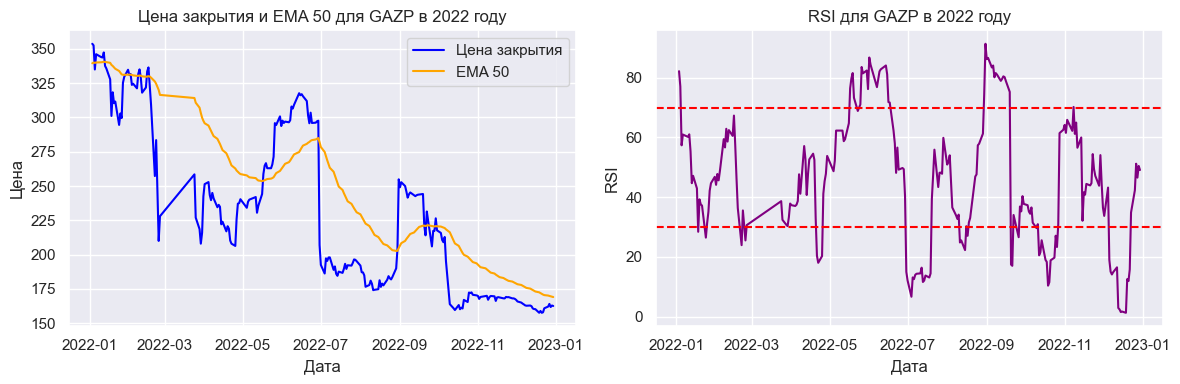

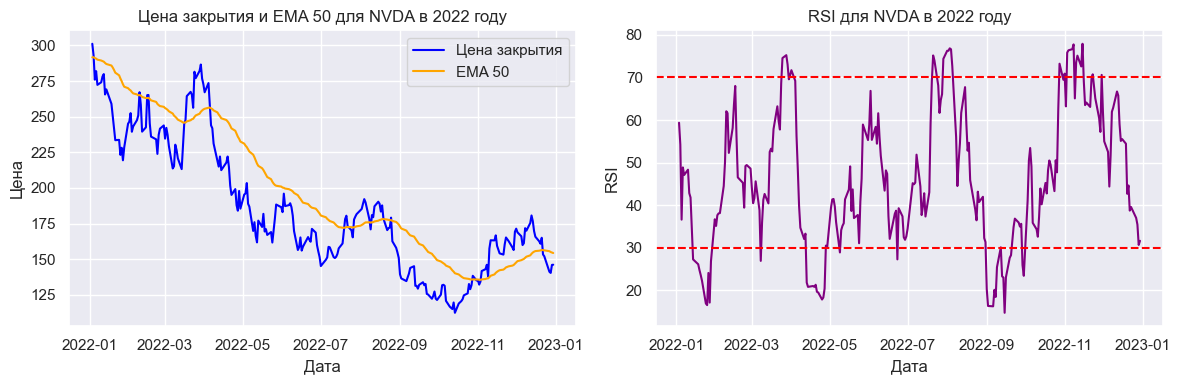

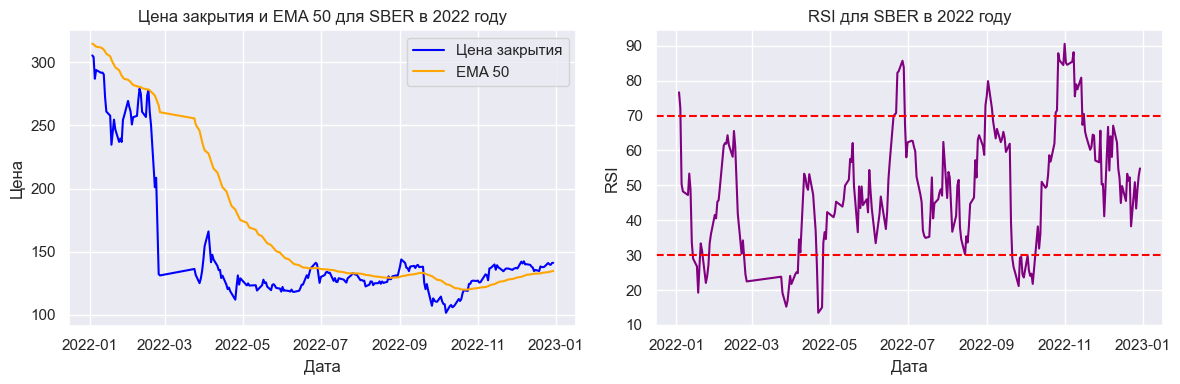

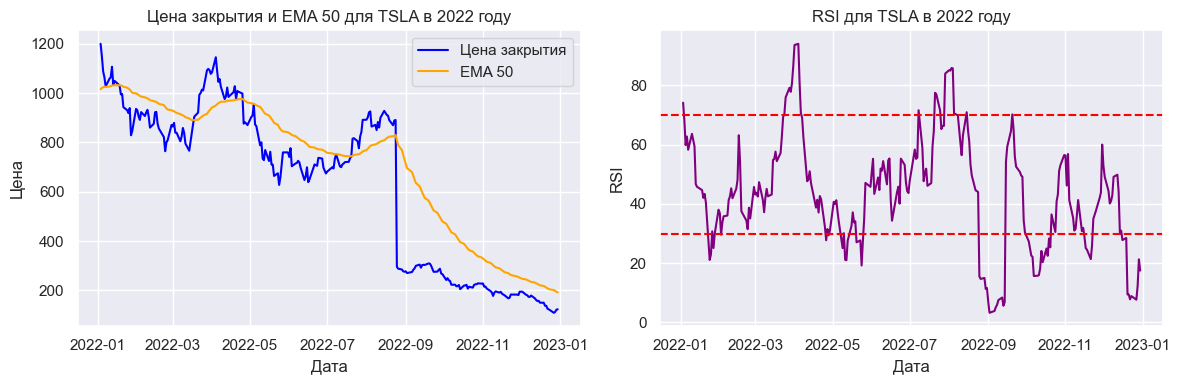

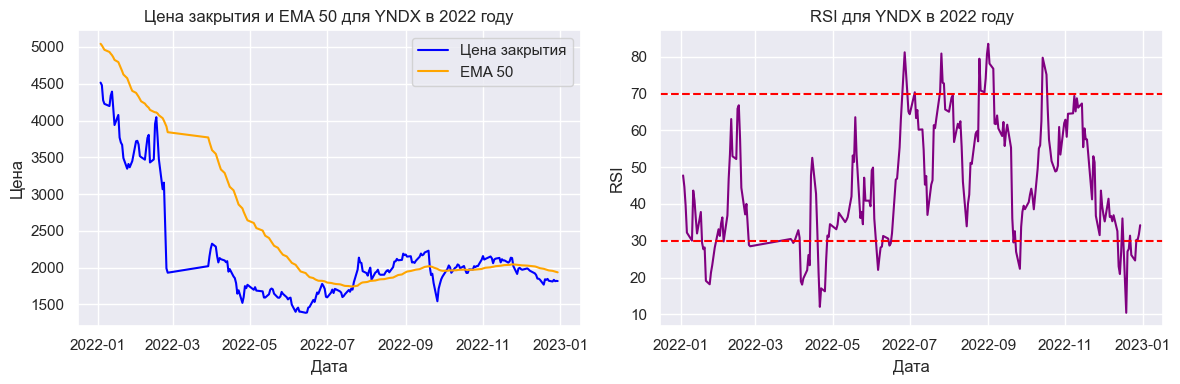

In [25]:
for ticker in tickers:
    plot_price_ema_rsi(ticker, 2022) 

Как мы видим из графиков, RSI часто находится выше верхней (70) или ниже нижней (30) линий. Это может иметь следующее значение:

- Когда RSI падает ниже уровня 30, это обычно интерпретируется как сигнал о том, что актив находится в состоянии перепроданности. Это может указывать на то, что цены упали слишком сильно и актив может быть недооценен, что потенциально создает возможность для покупки.
- Если RSI поднимается выше уровня 70, это часто считается сигналом о том, что актив находится в состоянии перекупленности. Это может предполагать, что цены поднялись слишком высоко и актив может быть переоценен, что может вести к коррекции или развороту цен вниз.

Однако, конечно же, важно помнить, что RSI - это всего лишь один из инструментов анализа, и его сигналы могут быть ложными, особенно в периоды высокой волатильности или на сильно трендовых рынках. Следовательно, рекомендуется использовать RSI в сочетании с другими индикаторами и методами анализа.